This notebook demonstrates how to use the **``openmc.mgxs``** module to generate multi-group cross sections with OpenMC.

**Note:** that this Notebook was created using [OpenMOC](https://mit-crpg.github.io/OpenMOC/) to verify the multi-group cross-sections generated by OpenMC. In order to run this Notebook, you must have [OpenMOC](https://mit-crpg.github.io/OpenMOC/) installed on your system, along with OpenCG to convert the OpenMC geometries into OpenMOC geometries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import openmc
import openmc.mgxs as mgxs
import openmoc
from openmoc.compatible import get_openmoc_geometry

%matplotlib inline

/usr/lib/pymodules/python2.7/matplotlib/__init__.py:1173: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Infinite Homogeneous Medium

We first construct a simple homogeneous infinite medium problem to illustrate use of the `openmc.mgxs` module to generate multi-group cross sections.

### Generate Inputs

First we need to define materials that will be used in the problem. Before defining a material, we must create nuclides that are used in the material.

In [2]:
# Instantiate some Nuclides
h1 = openmc.Nuclide('H-1')
o16 = openmc.Nuclide('O-16')
u235 = openmc.Nuclide('U-235')
u238 = openmc.Nuclide('U-238')
zr90 = openmc.Nuclide('Zr-90')

With the nuclides we defined, we will now create a material for the homogeneous medium.

In [3]:
# Instantiate a Material and register the Nuclides
inf_medium = openmc.Material(name='moderator')
inf_medium.set_density('g/cc', 5.)
inf_medium.add_nuclide(h1,  0.028999667)
inf_medium.add_nuclide(o16, 0.01450188)
inf_medium.add_nuclide(u235, 0.000114142)
inf_medium.add_nuclide(u238, 0.006886019)
inf_medium.add_nuclide(zr90, 0.002116053)

With our material, we can now create a materials file object that can be exported to an actual XML file.

In [4]:
# Instantiate a MaterialsFile, register all Materials, and export to XML
materials_file = openmc.MaterialsFile()
materials_file.default_xs = '71c'
materials_file.add_material(inf_medium)
materials_file.export_to_xml()

Now let's move on to the geometry. This problem will be a simple square cell with reflective boundary conditions to simulate an infinite homogeneous medium. The first step is to create the outer bounding surfaces of the problem.

In [5]:
# Instantiate boundary Planes
min_x = openmc.XPlane(boundary_type='reflective', x0=-0.63)
max_x = openmc.XPlane(boundary_type='reflective', x0=0.63)
min_y = openmc.YPlane(boundary_type='reflective', y0=-0.63)
max_y = openmc.YPlane(boundary_type='reflective', y0=0.63)

With the surfaces defined, we can now create a cell that is defined by intersections of half-spaces created by the surfaces.

In [6]:
# Instantiate a Cell
cell = openmc.Cell(cell_id=1, name='cell')

# Register bounding Surfaces with the Cell
cell.region = +min_x & -max_x & +min_y & -max_y

# Fill the Cell with the Material
cell.fill = inf_medium

OpenMC requires that there is a "root" universe. Let us create a root universe and add our square cell to it.

In [7]:
# Instantiate Universe
root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(cell)

We now must create a geometry that is assigned a root universe, put the geometry into a geometry file, and export it to XML.

In [8]:
# Create Geometry and set root Universe
openmc_geometry = openmc.Geometry()
openmc_geometry.root_universe = root_universe

# Instantiate a GeometryFile
geometry_file = openmc.GeometryFile()
geometry_file.geometry = openmc_geometry

# Export to "geometry.xml"
geometry_file.export_to_xml()

Next, we must define simulation parameters. In this case, we will use 10 inactive batches and 40 active batches each with 2500 particles.

In [9]:
# OpenMC simulation parameters
batches = 50
inactive = 10
particles = 2500

# Instantiate a SettingsFile
settings_file = openmc.SettingsFile()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': True, 'summary': True}
bounds = [-0.63, -0.63, -0.63, 0.63, 0.63, 0.63]
settings_file.set_source_space('box', bounds)

# Export to "settings.xml"
settings_file.export_to_xml()

Now we are finally ready to make use of the `openmc.mgxs` module to generate multi-group cross sections! First, let's define a "fine" 8-group and "coarse" 2-group structures using the built-in `EnergyGroups` class.

In [10]:
# Instantiate a "fine" 8-group EneryGroups object
fine_groups = mgxs.EnergyGroups()
fine_groups.group_edges = np.array([0., 0.058e-6, 0.14e-6, 0.28e-6,
                                    0.625e-6, 4.e-6, 5.53e-3, 821.e-3, 20.])

# Instantiate a "coarse" 2-group EneryGroups object
coarse_groups = mgxs.EnergyGroups()
coarse_groups.group_edges = np.array([0., 0.625e-6, 20.])

We can now use the fine and coarse `EnergyGroups` objects, along with our previously created materials and geometry, to instantiate some `MGXS` objects from the `openmc.mgxs` module. In particular, the following are subclasses of generic and abstract `MGXS` class:

* `TotalXS`
* `TransportXS`
* `AbsorptionXS`
* `CaptureXS`
* `FissionXS`
* `NuFissionXS`
* `ScatterXS`
* `NuScatterXS`
* `ScatterMatrixXS`
* `NuScatterMatrixXS`
* `Chi`

These classes provide us with an interface to generate the tally inputs as well as perform post-processing of OpenMC's tally data to compute the respective multi-group cross sections. In this case, let's create the multi-group cross sections needed to run an OpenMOC simulation to verify the accuracy of our cross sections. In particular, we will define total, nu-fission, nu-scatter and chi cross sections for our infinite medium cell as the domain and our fine 8-group structure as our energy groups.

In [11]:
# Instantiate cross sections needed for an OpenMOC simulation
transport = mgxs.TransportXS(domain=cell, domain_type='cell', groups=fine_groups)
nufission = mgxs.NuFissionXS(domain=cell, domain_type='cell', groups=fine_groups)
nuscatter = mgxs.NuScatterMatrixXS(domain=cell, domain_type='cell', groups=fine_groups)
chi = mgxs.Chi(domain=cell, domain_type='cell', groups=fine_groups)

Next, we must instruct our multi-group cross section objects to generate the tallies needed to calculate each of them in OpenMC. This can be done with the `MGXS.create_tallies()` routine.

In [12]:
# Instruct each multi-group cross section to generate tallies
transport.create_tallies()
nufission.create_tallies()
nuscatter.create_tallies()
chi.create_tallies()

Each multi-group cross section object stores its tallies in a Python dictionary called `tallies`. We can inspect the tallies in the dictionary for our `NuFission` object as follows. 

In [13]:
nufission.tallies

OrderedDict([('flux', Tally
	ID             =	10003
	Name           =	
	Filters        =	
                		cell	[1]
                		energy	[  0.00000000e+00   5.80000000e-08   1.40000000e-07   2.80000000e-07
   6.25000000e-07   4.00000000e-06   5.53000000e-03   8.21000000e-01
   2.00000000e+01]
	Nuclides       =	total 
	Scores         =	['flux']
	Estimator      =	tracklength
), ('nu-fission', Tally
	ID             =	10004
	Name           =	
	Filters        =	
                		cell	[1]
                		energy	[  0.00000000e+00   5.80000000e-08   1.40000000e-07   2.80000000e-07
   6.25000000e-07   4.00000000e-06   5.53000000e-03   8.21000000e-01
   2.00000000e+01]
	Nuclides       =	total 
	Scores         =	['nu-fission']
	Estimator      =	tracklength
)])

The `NuFission` object includes tracklength tallies for the 'nu-fission' and 'flux' scores in the 8-group structure in cell 1. Now that each multi-group cross section object contains the tallies that it needs, we must add these tallies to a `TalliesFile` object to generate the "tallies.xml" input file for OpenMC.

In [14]:
# Instantiate an empty TalliesFile
tallies_file = openmc.TalliesFile()

# Add transport tallies to the tallies file
for tally in transport.tallies.values():
    tallies_file.add_tally(tally, merge=True)

# Add nu-fission tallies to the tallies file
for tally in nufission.tallies.values():
    tallies_file.add_tally(tally, merge=True)

# Add nu-scatter tallies to the tallies file
for tally in nuscatter.tallies.values():
    tallies_file.add_tally(tally, merge=True)

# Add chi tallies to the tallies file    
for tally in chi.tallies.values():
    tallies_file.add_tally(tally, merge=True)
                
# Export to "tallies.xml"
tallies_file.export_to_xml()

Now we a have a complete set of inputs, so we can go ahead and run our simulation.

In [15]:
# Run OpenMC!
executor = openmc.Executor()
executor.run_simulation()


       .d88888b.                             888b     d888  .d8888b.
      d88P" "Y88b                            8888b   d8888 d88P  Y88b
      888     888                            88888b.d88888 888    888
      888     888 88888b.   .d88b.  88888b.  888Y88888P888 888       
      888     888 888 "88b d8P  Y8b 888 "88b 888 Y888P 888 888       
      888     888 888  888 88888888 888  888 888  Y8P  888 888    888
      Y88b. .d88P 888 d88P Y8b.     888  888 888   "   888 Y88b  d88P
       "Y88888P"  88888P"   "Y8888  888  888 888       888  "Y8888P"
__________________888______________________________________________________
                  888
                  888

      Copyright:      2011-2015 Massachusetts Institute of Technology
      License:        http://mit-crpg.github.io/openmc/license.html
      Version:        0.7.0
      Git SHA1:       170155e8d7935b57fad57bfad6aff1034a80206e
      Date/Time:      2015-10-15 16:52:26
      MPI Processes:  1

 =======================

0

### Tally Data Processing

Our simulation ran successfully and created a statepoint file with all the tally data in it. We begin our analysis here loading the statepoint file and 'reading' the results. By default, data from the statepoint file is only read into memory when it is requested. This helps keep the memory use to a minimum even when a statepoint file may be huge.

In [16]:
# Load the last statepoint file
sp = openmc.StatePoint('statepoint.50.h5')

In addition to the statepoint file, our simulation also created a summary file which encapsulates information about the materials and geometry which is necessary for the `openmc.mgxs` module to properly process the tally data. We first create a summary object and link it with the statepoint.

In [17]:
# Load the summary file and link it with the statepoint
su = openmc.Summary('summary.h5')
sp.link_with_summary(su)

The statepoint is now ready to be analyzed by our multi-group cross sections. The first step is to load the tallies from the statepoint into each object.

In [18]:
# Load the tallies from the statepoint into each MGXS object
transport.load_from_statepoint(sp)
nufission.load_from_statepoint(sp)
nuscatter.load_from_statepoint(sp)
chi.load_from_statepoint(sp)

The multi-group cross section objects can now use OpenMC's [tally arithmetic](http://mit-crpg.github.io/openmc/pythonapi/examples/pandas-dataframes.html) to compute cross sections from the tally data.

In [19]:
transport.compute_xs()
nufission.compute_xs()
nuscatter.compute_xs()
chi.compute_xs()

/usr/local/lib/python2.7/dist-packages/openmc-0.7.0-py2.7.egg/openmc/tallies.py:1487: RuntimeWarning: invalid value encountered in divide


Voila! Our multi-group cross sections are now ready to rock 'n roll!

### Cross Section Data Visualization

Let's first inspect our fission production cross section by printing it to the screen.

In [20]:
nufission.print_xs()

Multi-Group XS
	Reaction Type  =	nu-fission
	Domain Type    =	cell
	Domain ID      =	1
	Cross Sections [cm^-1]:
            Group 1 [0.821      - 20.0      MeV]:	1.11e-02 +/- 7.69e-01%
            Group 2 [0.00553    - 0.821     MeV]:	6.59e-04 +/- 2.97e-01%
            Group 3 [4e-06      - 0.00553   MeV]:	8.95e-03 +/- 5.12e-01%
            Group 4 [6.25e-07   - 4e-06     MeV]:	1.45e-02 +/- 7.10e-01%
            Group 5 [2.8e-07    - 6.25e-07  MeV]:	4.71e-02 +/- 1.02e+00%
            Group 6 [1.4e-07    - 2.8e-07   MeV]:	7.29e-02 +/- 8.86e-01%
            Group 7 [5.8e-08    - 1.4e-07   MeV]:	1.11e-01 +/- 6.67e-01%
            Group 8 [0.0        - 5.8e-08   MeV]:	2.38e-01 +/- 7.71e-01%





Since the `openmc.mgxs` module uses tally arithmetic under-the-hood, the cross section is stored as a "derived" tally. This means that it can be queried and manipulated using all of the same method supported for the `Tally` class in the OpenMC Python API. For example, we can construct a Pandas DataFrame of the multi-group cross section data.

In [21]:
df = nuscatter.get_pandas_dataframe()
df.head(10)

,cell,group in,group out,nuclide,mean,std. dev.
63,1,1,1,total,0.076970,0.001012
62,1,1,2,total,0.087876,0.000344
61,1,1,3,total,0.000418,0.000023
60,1,1,4,total,0.000000,0.000000
59,1,1,5,total,0.000000,0.000000
58,1,1,6,total,0.000000,0.000000
57,1,1,7,total,0.000000,0.000000
56,1,1,8,total,0.000000,0.000000
55,1,2,1,total,0.000000,0.000000
54,1,2,2,total,0.266499,0.001265


Each multi-group cross section object can be easily exported to a variety of file formats, including CSV, Excel, and LaTeX for storage or data processing.

In [22]:
transport.export_xs_data(filename='transport-xs', format='excel')

The following code snippet shows how to export all of four cross sections to the same HDF5 binary data store.

In [23]:
transport.build_hdf5_store(filename='mgxs', append=True)
nufission.build_hdf5_store(filename='mgxs', append=True)
nuscatter.build_hdf5_store(filename='mgxs', append=True)
chi.build_hdf5_store(filename='mgxs', append=True)

### Verification with OpenMOC

Of course it is always a good idea to verify that one's cross sections are accurate. We can easily do so here with the deterministic transport code OpenMOC. First, we will use OpenCG to reconstruct our OpenMC geometry from the summary file into a equivalent OpenMOC geometry.

In [24]:
# Create an OpenCG Geometry from the OpenMC Geometry stored in the summary
su.make_opencg_geometry()

# Create an OpenMOC Geometry from the OpenCG Geometry
openmoc_geometry = get_openmoc_geometry(su.opencg_geometry)

Now, we can inject the multi-group cross sections into the equivalent infinite homogeneous medium OpenMOC geometry.

In [25]:
# Get all OpenMOC cells in the gometry
openmoc_cells = openmoc_geometry.getRootUniverse().getAllCells()

# Inject multi-group cross sections into OpenMOC Materials
for cell_id, cell in openmoc_cells.items():
    
    # Get a reference to the Material filling this Cell
    openmoc_material = cell.getFillMaterial()
    
    # Set the number of energy groups for the Material
    openmoc_material.setNumEnergyGroups(fine_groups.num_groups)
    
    # Inject NumPy arrays of cross section data into the Material
    openmoc_material.setSigmaT(transport.get_xs().flatten())
    openmoc_material.setNuSigmaF(nufission.get_xs().flatten())
    openmoc_material.setSigmaS(nuscatter.get_xs().flatten())
    openmoc_material.setChi(chi.get_xs().flatten())

We are now ready to run OpenMOC to verify our cross-sections from OpenMC.

In [26]:
# Generate tracks for OpenMOC
openmoc_geometry.initializeFlatSourceRegions()
track_generator = openmoc.TrackGenerator(openmoc_geometry, 128, 0.1)
track_generator.generateTracks()

# Run OpenMOC
solver = openmoc.CPUSolver(track_generator)
solver.computeEigenvalue()

[  NORMAL ]  Ray tracing for track segmentation...
[  NORMAL ]  Dumping tracks to file...
[  NORMAL ]  Computing the eigenvalue...
[  NORMAL ]  Iteration 0:	k_eff = 0.685184	res = 1.498E-316
[  NORMAL ]  Iteration 1:	k_eff = 0.785642	res = 3.148E-01
[  NORMAL ]  Iteration 2:	k_eff = 0.750185	res = 1.466E-01
[  NORMAL ]  Iteration 3:	k_eff = 0.728846	res = 4.513E-02
[  NORMAL ]  Iteration 4:	k_eff = 0.695632	res = 2.844E-02
[  NORMAL ]  Iteration 5:	k_eff = 0.663357	res = 4.557E-02
[  NORMAL ]  Iteration 6:	k_eff = 0.632339	res = 4.640E-02
[  NORMAL ]  Iteration 7:	k_eff = 0.604187	res = 4.676E-02
[  NORMAL ]  Iteration 8:	k_eff = 0.579451	res = 4.452E-02
[  NORMAL ]  Iteration 9:	k_eff = 0.558474	res = 4.094E-02
[  NORMAL ]  Iteration 10:	k_eff = 0.541436	res = 3.620E-02
[  NORMAL ]  Iteration 11:	k_eff = 0.528380	res = 3.051E-02
[  NORMAL ]  Iteration 12:	k_eff = 0.519273	res = 2.411E-02
[  NORMAL ]  Iteration 13:	k_eff = 0.513991	res = 1.724E-02
[  NORMAL ]  Iteration 14:	k_eff = 0.5

We report the eigenvalues computed by OpenMC and OpenMOC here together to summarize our results.

In [27]:
# Print report of keff and bias with OpenMC
openmoc_keff = solver.getKeff()
openmc_keff = sp.k_combined[0]
bias = (openmoc_keff - openmc_keff) * 1e5

print('openmc keff = {0:1.6f}'.format(openmc_keff))
print('openmoc keff = {0:1.6f}'.format(openmoc_keff))
print('bias [pcm]: {0:1.1f}'.format(bias))

openmc keff = 1.161200
openmoc keff = 1.160876
bias [pcm]: -32.4


Although there is a non-trivial bias, one can easily run the preceding code with more particle histories to show that both codes converge to the same eigenvalue with <10 pcm bias. It should be noted that this discrepancy is due to use of tracklength tallies for `NuFission`, while one must use more slowly converging analog tallies for `TransportXS`, `NuScatterMatrixXS` and `Chi` (which require an 'energyout' filter).

# Fuel Pin Cell

In this section we show how to compute multi-group cross sections for a fuel pin cell. In addition, we will illustrate how to use some of the more advanced features in `openmc.mgxs` such as nuclide-by-nuclide microscopic cross section tallies and downstream energy group condensation.

### Generate Inputs

this time we separate our nuclides into three distinct materials for water, clad and fuel.

In [28]:
# 1.6 enriched fuel
fuel = openmc.Material(name='1.6% Fuel')
fuel.set_density('g/cm3', 10.31341)
fuel.add_nuclide(u235, 3.7503e-4)
fuel.add_nuclide(u238, 2.2625e-2)
fuel.add_nuclide(o16, 4.6007e-2)

# borated water
water = openmc.Material(name='Borated Water')
water.set_density('g/cm3', 0.740582)
water.add_nuclide(h1, 4.9457e-2)
water.add_nuclide(o16, 2.4732e-2)

# zircaloy
zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_nuclide(zr90, 7.2758e-3)

With our materials, we can now create a materials file object that can be exported to an actual XML file.

In [29]:
# Instantiate a MaterialsFile, add Materials
materials_file = openmc.MaterialsFile()
materials_file.add_material(fuel)
materials_file.add_material(water)
materials_file.add_material(zircaloy)
materials_file.default_xs = '71c'

# Export to "materials.xml"
materials_file.export_to_xml()

Now let's move on to the geometry. Our problem will have three regions for the fuel, the clad, and the surrounding coolant. The first step is to create the bounding surfaces -- in this case two cylinders and six reflective planes.

In [30]:
# Create cylinders for the fuel and clad
fuel_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.39218)
clad_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.45720)

# Create boundary planes to surround the geometry
# Use both reflective and vacuum boundaries to make life interesting
min_x = openmc.XPlane(x0=-0.63, boundary_type='reflective')
max_x = openmc.XPlane(x0=+0.63, boundary_type='reflective')
min_y = openmc.YPlane(y0=-0.63, boundary_type='reflective')
max_y = openmc.YPlane(y0=+0.63, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-0.63, boundary_type='reflective')
max_z = openmc.ZPlane(z0=+0.63, boundary_type='reflective')

With the surfaces defined, we can now create cells that are defined by intersections of half-spaces created by the surfaces.

In [31]:
# Create a Universe to encapsulate a fuel pin
pin_cell_universe = openmc.Universe(name='1.6% Fuel Pin')

# Create fuel Cell
fuel_cell = openmc.Cell(name='1.6% Fuel')
fuel_cell.fill = fuel
fuel_cell.region = -fuel_outer_radius
pin_cell_universe.add_cell(fuel_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='1.6% Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
pin_cell_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='1.6% Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius
pin_cell_universe.add_cell(moderator_cell)

OpenMC requires that there is a "root" universe. Let us create a root cell that is filled by the pin cell universe and then assign it to the root universe.

In [32]:
# Create root Cell
root_cell = openmc.Cell(name='root cell')
root_cell.region = +min_x & -max_x & +min_y & -max_y
root_cell.fill = pin_cell_universe

# Create root Universe
root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(root_cell)

We now must create a geometry that is assigned a root universe, put the geometry into a geometry file, and export it to XML.

In [33]:
# Create Geometry and set root Universe
openmc_geometry = openmc.Geometry()
openmc_geometry.root_universe = root_universe

# Instantiate a GeometryFile
geometry_file = openmc.GeometryFile()
geometry_file.geometry = openmc_geometry

# Export to "geometry.xml"
geometry_file.export_to_xml()

We will reuse our settings from the previous simulation. Now, we let's create transport, nu-fission, nu-scatter and chi multi-group cross sections for each cell.

In [34]:
# Extract all Cells filled by Materials
openmc_cells = openmc_geometry.get_all_material_cells()

# Create dictionary to store multi-group cross sections for all cells
xs_library = {}

# Instantiate 8-group cross sections for each cell
for cell in openmc_cells:
    xs_library[cell.id] = {}
    xs_library[cell.id]['transport']  = mgxs.TransportXS(groups=fine_groups)
    xs_library[cell.id]['nu-fission'] = mgxs.NuFissionXS(groups=fine_groups)
    xs_library[cell.id]['nu-scatter'] = mgxs.NuScatterMatrixXS(groups=fine_groups)
    xs_library[cell.id]['chi'] = mgxs.Chi(groups=fine_groups)

In [35]:
# Create a tally trigger set to 10% on the relative error
tally_trigger = openmc.Trigger('rel_err', 1E-1)

# Add the tally trigger to each of the multi-group cross section tallies
for cell in openmc_cells:
    for mgxs_type in xs_library[cell.id].keys():
        xs_library[cell.id][mgxs_type].tally_trigger = tally_trigger
        
# Set the trigger to active in the "settings.xml" file
settings_file.trigger_active = True
settings_file.trigger_max_batches = settings_file.batches * 2
settings_file.export_to_xml()

In this case, we did not give our cross sections a spatial domain in their constructors. Instead, we will loop over all cells to set each cross sections domain. In addition, we will set each cross section to tally cross sections on a per-nuclide basis through the use of the `by_nuclide` instance attribute.  

In [36]:
# Instantiate an empty TalliesFile
tallies_file = openmc.TalliesFile()

# Iterate over all cells and cross section types
for cell in openmc_cells:
    for rxn_type in xs_library[cell.id].keys():

        # Set the cross sections domain type to the cell
        xs_library[cell.id][rxn_type].domain = cell
        xs_library[cell.id][rxn_type].domain_type = 'cell'
        
        # Tally cross sections by nuclide (e.g., micro cross sections)
        xs_library[cell.id][rxn_type].by_nuclide = True
        
        # Create OpenMC tallies for this cross section
        xs_library[cell.id][rxn_type].create_tallies()
                
        # Add OpenMC tallies to the tallies file for XML generation
        for tally in xs_library[cell.id][rxn_type].tallies.values():
            tallies_file.add_tally(tally, merge=True)

# Export to "tallies.xml"
tallies_file.export_to_xml()

Now we a have a complete set of inputs, so we can go ahead and run our simulation.

In [37]:
# Delete old HDF5 files
!rm *.h5

# Run OpenMC with the output throttled!
executor = openmc.Executor()
executor.run_simulation(output=True)


       .d88888b.                             888b     d888  .d8888b.
      d88P" "Y88b                            8888b   d8888 d88P  Y88b
      888     888                            88888b.d88888 888    888
      888     888 88888b.   .d88b.  88888b.  888Y88888P888 888       
      888     888 888 "88b d8P  Y8b 888 "88b 888 Y888P 888 888       
      888     888 888  888 88888888 888  888 888  Y8P  888 888    888
      Y88b. .d88P 888 d88P Y8b.     888  888 888   "   888 Y88b  d88P
       "Y88888P"  88888P"   "Y8888  888  888 888       888  "Y8888P"
__________________888______________________________________________________
                  888
                  888

      Copyright:      2011-2015 Massachusetts Institute of Technology
      License:        http://mit-crpg.github.io/openmc/license.html
      Version:        0.7.0
      Git SHA1:       170155e8d7935b57fad57bfad6aff1034a80206e
      Date/Time:      2015-10-15 16:52:53
      MPI Processes:  1

 =======================

0

### Tally Data Processing

Our simulation ran successfully and created a statepoint file with all the tally data in it. As before, we begin our analysis here loading the statepoint file.

In [38]:
# Load the last statepoint and summary files
sp = openmc.StatePoint('statepoint.050.h5')
su = openmc.Summary('summary.h5')
sp.link_with_summary(su)

The statepoint is now ready to be analyzed by our multi-group cross sections. Next, we load the tallies from the statepoint into each object and to compute the cross sections using tally arithmetic.

In [39]:
# Iterate over all cells and cross section types
for cell in openmc_cells:
    for rxn_type in xs_library[cell.id].keys():
        xs_library[cell.id][rxn_type].load_from_statepoint(sp)
        xs_library[cell.id][rxn_type].compute_xs()

That's it! Our multi-group cross sections are now ready for the big spotlight. This time we have cross sections in three distinct spatial zones - fuel, clad and moderator - on a per-nuclide basis.

### Cross Section Data Visualization

Let's first inspect one of our cross sections by printing it to the screen as a microscopic cross section in units of barns.

In [40]:
nufission = xs_library[fuel_cell.id]['nu-fission']
nufission.print_xs(xs_type='micro', nuclides=['U-235', 'U-238'])

Multi-Group XS
	Reaction Type  =	nu-fission
	Domain Type    =	cell
	Domain ID      =	10000
	Nuclide        =	U-235
	Cross Sections [barns]:
            Group 1 [0.821      - 20.0      MeV]:	3.30e+00 +/- 5.91e-01%
            Group 2 [0.00553    - 0.821     MeV]:	3.97e+00 +/- 4.03e-01%
            Group 3 [4e-06      - 0.00553   MeV]:	5.48e+01 +/- 5.56e-01%
            Group 4 [6.25e-07   - 4e-06     MeV]:	8.84e+01 +/- 8.48e-01%
            Group 5 [2.8e-07    - 6.25e-07  MeV]:	2.89e+02 +/- 1.25e+00%
            Group 6 [1.4e-07    - 2.8e-07   MeV]:	4.49e+02 +/- 1.09e+00%
            Group 7 [5.8e-08    - 1.4e-07   MeV]:	6.87e+02 +/- 7.98e-01%
            Group 8 [0.0        - 5.8e-08   MeV]:	1.44e+03 +/- 5.73e-01%

	Nuclide        =	U-238
	Cross Sections [barns]:
            Group 1 [0.821      - 20.0      MeV]:	1.06e+00 +/- 6.74e-01%
            Group 2 [0.00553    - 0.821     MeV]:	1.22e-03 +/- 8.28e-01%
            Group 3 [4e-06      - 0.00553   MeV]:	4.75e-04 +/- 7.97e+00%
       

Our multi-group cross sections are capable of summing across all nuclides to provide us with macroscopic cross sections as well.

In [41]:
nufission = xs_library[fuel_cell.id]['nu-fission']
nufission.print_xs(xs_type='macro', nuclides='sum')

Multi-Group XS
	Reaction Type  =	nu-fission
	Domain Type    =	cell
	Domain ID      =	10000
	Cross Sections [cm^-1]:
            Group 1 [0.821      - 20.0      MeV]:	2.52e-02 +/- 6.42e-01%
            Group 2 [0.00553    - 0.821     MeV]:	1.52e-03 +/- 3.96e-01%
            Group 3 [4e-06      - 0.00553   MeV]:	2.06e-02 +/- 5.56e-01%
            Group 4 [6.25e-07   - 4e-06     MeV]:	3.32e-02 +/- 8.48e-01%
            Group 5 [2.8e-07    - 6.25e-07  MeV]:	1.09e-01 +/- 1.25e+00%
            Group 6 [1.4e-07    - 2.8e-07   MeV]:	1.69e-01 +/- 1.09e+00%
            Group 7 [5.8e-08    - 1.4e-07   MeV]:	2.58e-01 +/- 7.98e-01%
            Group 8 [0.0        - 5.8e-08   MeV]:	5.41e-01 +/- 5.73e-01%





Although a printed report is nice, it is not scalable or flexible. Let's extract the cross section data for the moderator as a Pandas DataFrame.

In [42]:
nuscatter = xs_library[moderator_cell.id]['nu-scatter']
df = nuscatter.get_pandas_dataframe(xs_type='micro')
df.head(10)

,cell,group in,group out,nuclide,mean,std. dev.
126,10002,1,1,H-1,0.234877,0.010096
127,10002,1,1,O-16,1.560098,0.017801
124,10002,1,2,H-1,1.587815,0.007847
125,10002,1,2,O-16,0.288236,0.004397
122,10002,1,3,H-1,0.010122,0.000513
123,10002,1,3,O-16,0.000000,0.000000
120,10002,1,4,H-1,0.000000,0.000000
121,10002,1,4,O-16,0.000000,0.000000
118,10002,1,5,H-1,0.000000,0.000000
119,10002,1,5,O-16,0.000000,0.000000


We can easily use the Pandas DataFrame to extract the H-1 and O-16 scattering matrices separately.

In [43]:
# Slice DataFrame in two for each nuclide's mean values
h1 = df[df['nuclide'] == 'H-1']['mean']
o16 = df[df['nuclide'] == 'O-16']['mean']

# Cast DataFrames as NumPy arrays
h1 = h1.as_matrix()
o16 = o16.as_matrix()

# Reshape arrays to 2D matrix for plotting
h1.shape = (fine_groups.num_groups, fine_groups.num_groups)
o16.shape = (fine_groups.num_groups, fine_groups.num_groups)

Matplotlib's `imshow` routine can be used to plot the matrices to illustrate their sparsity structures.

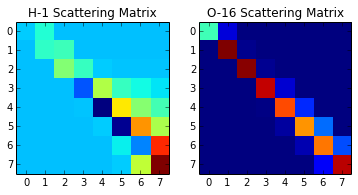

In [44]:
# Create plot of the H-1 scattering matrix
fig = plt.subplot(121)
fig.imshow(h1, interpolation='nearest')
plt.title('H-1 Scattering Matrix')

# Create plot of the O-16 scattering matrix
fig2 = plt.subplot(122)
fig2.imshow(o16, interpolation='nearest')
plt.title('O-16 Scattering Matrix')

# Show the plot on screen
plt.show()

Next, we illustate how one can easily take multi-group cross sections and condense them down to a coarser energy group structure using. The `get_condensed_xs(...)` class method takes in as a parameter an `EnergyGroups` object with a coarse(r) group structure and returns a new multi-group cross section condensed to the coarse groups. We illustrate this process below using the 2-group structure created earlier.

In [45]:
# Extract the 16-group transport cross section for the fuel
fine_xs = xs_library[fuel_cell.id]['transport']

# Condense to the 2-group structure
condense_xs = fine_xs.get_condensed_xs(coarse_groups)

Group condensation is as simple as that! We now have a new coarse 2-group cross section in addition to our original 16-group cross section. Let's inspect the 2-group cross section by printing it to the screen and extracting a Pandas DataFrame as we have already learned how to do.

In [46]:
condense_xs.print_xs()

Multi-Group XS
	Reaction Type  =	transport
	Domain Type    =	cell
	Domain ID      =	10000
	Nuclide        =	U-235
	Cross Sections [cm^-1]:
            Group 1 [6.25e-07   - 20.0      MeV]:	7.91e-03 +/- 1.22e+00%
            Group 2 [0.0        - 6.25e-07  MeV]:	1.82e-01 +/- 4.98e-01%

	Nuclide        =	U-238
	Cross Sections [cm^-1]:
            Group 1 [6.25e-07   - 20.0      MeV]:	2.17e-01 +/- 4.04e-01%
            Group 2 [0.0        - 6.25e-07  MeV]:	2.53e-01 +/- 5.85e-01%

	Nuclide        =	O-16
	Cross Sections [cm^-1]:
            Group 1 [6.25e-07   - 20.0      MeV]:	1.45e-01 +/- 4.10e-01%
            Group 2 [0.0        - 6.25e-07  MeV]:	1.75e-01 +/- 6.46e-01%





In [47]:
df = condense_xs.get_pandas_dataframe(xs_type='micro')
df

,cell,group in,nuclide,mean,std. dev.
3,10000,1,U-235,21.095256,0.257787
4,10000,1,U-238,9.589323,0.038756
5,10000,1,O-16,3.159101,0.012939
0,10000,2,U-235,485.513530,2.418761
1,10000,2,U-238,11.178844,0.065428
2,10000,2,O-16,3.800027,0.024538


### Verification with OpenMOC

Finally, let's verify our cross sections using OpenMOC. First, we use OpenCG construct an equivalent OpenMOC geometry just as we did before.

In [48]:
# Create an OpenCG Geometry from the OpenMC Geometry stored in the summary
su.make_opencg_geometry()

# Create an OpenMOC Geometry from the OpenCG Geometry
openmoc_geometry = get_openmoc_geometry(su.opencg_geometry)

Likewise, we can inject the multi-group cross sections into the equivalent fuel pin cell OpenMOC geometry.

In [49]:
# Get all OpenMOC cells in the gometry
openmoc_cells = openmoc_geometry.getRootUniverse().getAllCells()

# Inject multi-group cross sections into OpenMOC Materials
# NOTE: This code will work for 1, 10, or 1,000s of cells
# as is the case for a complicated geometry like BEAVRS
for cell_id, cell in openmoc_cells.items():
    
    # Ignore the root cell
    if cell.getName() == 'root cell':
        continue
    
    # Get a reference to the Material filling this Cell
    openmoc_material = cell.getFillMaterial()
    
    # Set the number of energy groups for the Material
    openmoc_material.setNumEnergyGroups(fine_groups.num_groups)
    
    # Extract the appropriate cross section objects for this cell
    transport = xs_library[cell_id]['transport']
    nufission = xs_library[cell_id]['nu-fission']
    nuscatter = xs_library[cell_id]['nu-scatter']
    chi = xs_library[cell_id]['chi']
    
    # Inject NumPy arrays of cross section data into the Material
    # NOTE: In each case we must sum across nuclides to get the
    # macroscopic cross sections needed by OpenMOC
    openmoc_material.setSigmaT(transport.get_xs(nuclides='sum').flatten())
    openmoc_material.setNuSigmaF(nufission.get_xs(nuclides='sum').flatten())
    openmoc_material.setSigmaS(nuscatter.get_xs(nuclides='sum').flatten())
    openmoc_material.setChi(chi.get_xs(nuclides='sum').flatten())

We are now ready to run OpenMOC to verify our cross-sections from OpenMC.

In [50]:
# Throttle OpenMOC output to screen
openmoc.log.set_log_level('WARNING')

# Generate tracks for OpenMOC
openmoc_geometry.initializeFlatSourceRegions()
track_generator = openmoc.TrackGenerator(openmoc_geometry, 128, 0.1)
track_generator.generateTracks()

# Run OpenMOC
solver = openmoc.CPUSolver(track_generator)
solver.computeEigenvalue()

We report the eigenvalues computed by OpenMC and OpenMOC here together to summarize our results.

In [51]:
# Print report of keff and bias with OpenMC
openmoc_keff = solver.getKeff()
openmc_keff = sp.k_combined[0]
bias = (openmoc_keff - openmc_keff) * 1e5

print('openmc keff = {0:1.6f}'.format(openmc_keff))
print('openmoc keff = {0:1.6f}'.format(openmoc_keff))
print('bias [pcm]: {0:1.1f}'.format(bias))

openmc keff = 1.227616
openmoc keff = 1.225322
bias [pcm]: -229.3


As a sanity check, let's run a simulation with the coarse 2-group cross sections to ensure that they produce a reasonable result.

In [52]:
su.make_opencg_geometry()
openmoc_geometry = get_openmoc_geometry(su.opencg_geometry)
openmoc_cells = openmoc_geometry.getRootUniverse().getAllCells()

# Inject multi-group cross sections into OpenMOC Materials
for cell_id, cell in openmoc_cells.items():
    
    # Ignore the root cell
    if cell.getName() == 'root cell':
        continue
    
    openmoc_material = cell.getFillMaterial()
    openmoc_material.setNumEnergyGroups(coarse_groups.num_groups)
    
    # Extract the appropriate cross section objects for this cell
    transport = xs_library[cell_id]['transport']
    nufission = xs_library[cell_id]['nu-fission']
    nuscatter = xs_library[cell_id]['nu-scatter']
    chi = xs_library[cell_id]['chi']
    
    # Perform group condensation
    transport = transport.get_condensed_xs(coarse_groups)
    nufission = nufission.get_condensed_xs(coarse_groups)
    nuscatter = nuscatter.get_condensed_xs(coarse_groups)
    chi = chi.get_condensed_xs(coarse_groups)
    
    # Inject NumPy arrays of cross section data into the Material
    openmoc_material.setSigmaT(transport.get_xs(nuclides='sum').flatten())
    openmoc_material.setNuSigmaF(nufission.get_xs(nuclides='sum').flatten())
    openmoc_material.setSigmaS(nuscatter.get_xs(nuclides='sum').flatten())
    openmoc_material.setChi(chi.get_xs(nuclides='sum').flatten())

In [53]:
# Generate tracks for OpenMOC
openmoc_geometry.initializeFlatSourceRegions()
track_generator = openmoc.TrackGenerator(openmoc_geometry, 128, 0.1)
track_generator.generateTracks()

# Run OpenMOC
solver = openmoc.CPUSolver(track_generator)
solver.computeEigenvalue()

In [54]:
# Print report of keff and bias with OpenMC
openmoc_keff = solver.getKeff()
openmc_keff = sp.k_combined[0]
bias = (openmoc_keff - openmc_keff) * 1e5

print('openmc keff = {0:1.6f}'.format(openmc_keff))
print('openmoc keff = {0:1.6f}'.format(openmoc_keff))
print('bias [pcm]: {0:1.1f}'.format(bias))

openmc keff = 1.227616
openmoc keff = 1.227093
bias [pcm]: -52.3


There is a non-trivial bias in both the 2-group and 8-group cases. In the case of the pin cell, one can show that these biases do not converge to <100 pcm with more particle histories. In the case of heterogeneous geometries, additional measures must be taken to address the following three sources of bias:

* Appropriate transport-corrected cross sections
* Spatial discretization of OpenMOC's mesh
* Constant-in-angle multi-group cross sections